Датасет был взят из этой статьи: https://medium.com/@max.bobkov/machine-learning-moscow-flats-appraising-25a1e9f171db

In [78]:
import pandas as pd
import numpy as np

import folium
import geopy.distance

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [79]:
sns.set_style('darkgrid')

<font size ='5'><b>Задачи:</b></font>
    
<font size ='4'>- визуализировать распределения параметров, имеющихся в данных, и сделать на этой основе выводы</font>

<font size ='4'>- выяснить, при помощи каких параметров мы можем наиболее эффективно предсказывать цену жилья</font>

<font size ='4'>- нанести на карту квартиры, подходящие по определённым критериям</font>

In [80]:
df = pd.read_csv('moscow_dataset_2020.csv')
df.head()

,wallsMaterial,floorNumber,floorsTotal,totalArea,kitchenArea,latitude,longitude,price
0,brick,1,5.0,18.0,3.0,55.723379,37.628577,5600000
1,brick,1,5.0,15.0,3.0,55.725980,37.671031,4650000
2,brick,1,5.0,11.9,1.5,55.735976,37.657817,2990000
3,brick,1,7.0,18.4,3.0,55.786698,37.595321,4390000
4,brick,2,5.0,17.6,2.0,55.767894,37.665920,4890000


Описание данных:
- `wallsMaterial` - материал, из которого сделаны стены
- `floorNumber` - этаж, на котором распологается квартира/комната
- `floorsTotal` - общая этажность дома:
- `totalArea` - площадь квартиры/комнаты
- `kitchenArea` - площадь кухни
- `latitude` - широта
- `longitude` - долгота
- `price` - цена (руб.)

## Знакомство с данными

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63945 entries, 0 to 63944
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wallsMaterial  63945 non-null  object 
 1   floorNumber    63945 non-null  int64  
 2   floorsTotal    63945 non-null  float64
 3   totalArea      63945 non-null  float64
 4   kitchenArea    63945 non-null  float64
 5   latitude       63945 non-null  float64
 6   longitude      63945 non-null  float64
 7   price          63945 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 3.9+ MB


In [82]:
df.duplicated().sum() # Имеется 2641 полный дубликат

2641

Посмотрим, что это за дубликаты

In [83]:
df[(df.duplicated())].head()

,wallsMaterial,floorNumber,floorsTotal,totalArea,kitchenArea,latitude,longitude,price
6,brick,5,9.0,21.5,3.0,55.784066,37.637425,8050000
25,brick,3,10.0,31.2,7.0,55.775894,37.595564,11500000
26,brick,3,10.0,31.2,7.0,55.775894,37.595564,11500000
96,monolith,50,65.0,40.0,8.0,55.751143,37.533733,20112960
304,brick,1,4.0,61.7,7.0,55.729610,37.571363,18500000


In [84]:
df[(df.price == 8050000)].head()

,wallsMaterial,floorNumber,floorsTotal,totalArea,kitchenArea,latitude,longitude,price
5,brick,5,9.0,21.5,3.0,55.784066,37.637425,8050000
6,brick,5,9.0,21.5,3.0,55.784066,37.637425,8050000
881,monolith,6,24.0,42.5,11.9,55.880576,37.542096,8050000
7152,monolith,12,12.0,47.3,16.0,55.575480,37.471623,8050000
10279,panel,4,17.0,38.0,7.5,55.858897,37.500118,8050000


Действительно имеются полные дубликаты, но так как мы знаем, что данные были предварительно очищены создателем датасета, то здесь есть несколько вариантов:
- дубликаты всё же остались
- квартиры на одном этаже сдаются разными людьми
- человек владеет нескольими квартирами на этаже
- квартиры продаёт застройщик (но тогда и остальные этаже так же должны продаваться


In [85]:
df[(df.latitude == 55.784066) & (df.longitude == 37.697469)].head() 
# Тут, например, в одном доме продаётся много квартир => новостройка. Оставим все имеющиеся дубликаты

,wallsMaterial,floorNumber,floorsTotal,totalArea,kitchenArea,latitude,longitude,price
42100,monolith,15,21.0,50.2,10.0,55.784066,37.697469,13915440
42101,monolith,15,21.0,50.0,10.0,55.784066,37.697469,13915440
42965,monolith,3,21.0,71.8,10.0,55.784066,37.697469,17124300
42966,monolith,5,21.0,70.9,10.0,55.784066,37.697469,17292510
42967,monolith,6,21.0,70.9,10.0,55.784066,37.697469,17483940


In [86]:
df.shape

(63945, 8)

In [87]:
df.isna().sum() # Пропусков значений нет

wallsMaterial    0
floorNumber      0
floorsTotal      0
totalArea        0
kitchenArea      0
latitude         0
longitude        0
price            0
dtype: int64

Добавим ещё один параметр - расстояние до Кремля. Для этого возьмём координаты Кремля и посчитаем расстояние между домами и центром Москвы. Для этого воспользуемся библиотекой geopy.

In [88]:
def calc_distance(row, site_coords):
    station_coords = (row['latitude'], row['longitude'])
    d = geopy.distance.distance(site_coords, station_coords).km
    return(d)

df['distance_to_center'] = df.apply(calc_distance, site_coords=(55.75356703456245,37.62222896032712), axis=1).round(0)

## Визуализация

Визуализируем распределения имеющихся показателей.

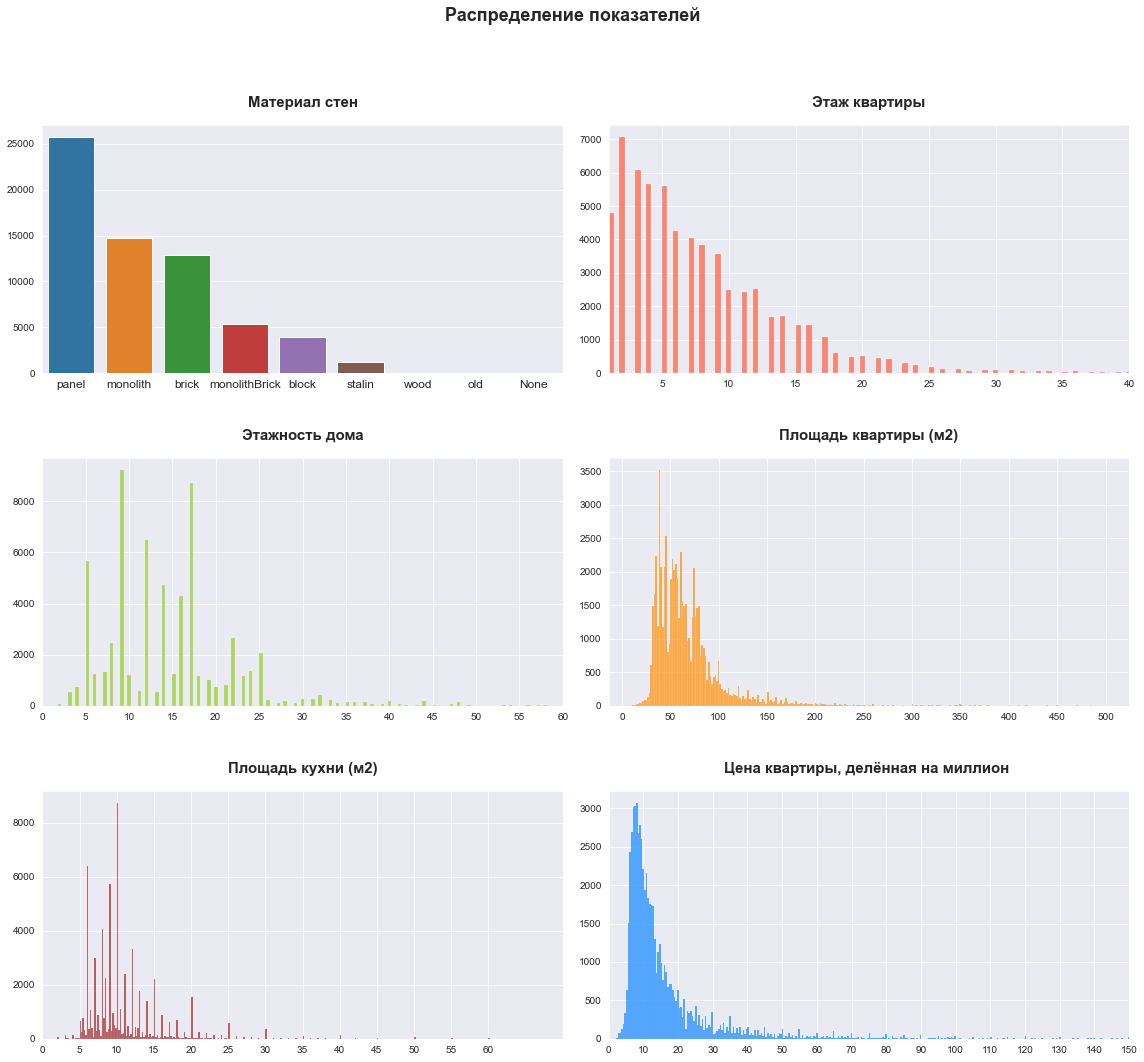

In [89]:
price_ed = df['price'] / 1000000 
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,14))
fig.suptitle('Распределение показателей', fontsize=18, fontweight='bold', y=1.05)


sns.countplot(data=df, x='wallsMaterial', ax=ax1, order = df['wallsMaterial'].value_counts().index)
ax1.set(xlabel=None, ylabel=None);
ax1.set_title('Материал стен', fontsize=15, fontweight='bold', y=1.05);
ax1.tick_params(axis='x', labelsize=12)

sns.histplot(df, x='floorNumber', color='tomato', ax=ax2)
ax2.set(xlim=(1, 40), xlabel=None, ylabel=None)
ax2.set_title('Этаж квартиры', fontsize=15, fontweight='bold', y=1.05);

sns.histplot(df, x='floorsTotal', color='yellowgreen', ax=ax3)
ax3.set(xlim=(1, 60), xlabel=None, ylabel=None)
ax3.set_title('Этажность дома', fontsize=15, fontweight='bold', y=1.05);
ax3.set_xticks(np.arange(0, 61, 5))

sns.histplot(df, x='totalArea', color='darkorange', ax=ax4)
ax4.set(xlabel=None, ylabel=None);
ax4.set_title('Площадь квартиры (м2)', fontsize=15, fontweight='bold', y=1.05);
ax4.set_xticks(np.arange(0, 501, 50))

sns.histplot(df, x='kitchenArea', color='brown', ax=ax5)
ax5.set(xlabel=None, ylabel=None, xlim=(0, 70));
ax5.set_title('Площадь кухни (м2)', fontsize=15, fontweight='bold', y=1.05);
ax5.set_xticks(np.arange(0, 61, 5))

sns.histplot(price_ed, color='dodgerblue', ax=ax6)
ax6.set(xlim=(0, 150), xlabel=None, ylabel=None)
ax6.set_title('Цена квартиры, делённая на миллион ', fontsize=15, fontweight='bold', y=1.05);
ax6.set_xticks(np.arange(0, 151, 10))

plt.tight_layout(h_pad=4)

D:\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


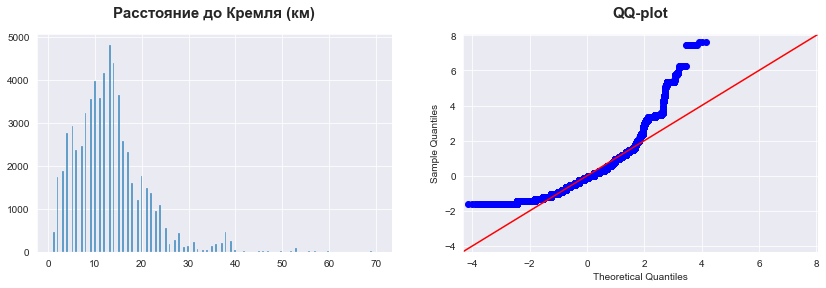

In [90]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df, x='distance_to_center', ax=ax1);
ax1.set(xlabel=None, ylabel=None);
ax1.set_title('Расстояние до Кремля (км)', fontsize=15, fontweight='bold', y=1.05);

sm.qqplot(df.distance_to_center, fit=True, line='45', ax=ax2);
ax2.set_title('QQ-plot', fontsize=15, fontweight='bold', y=1.05);

In [91]:
print(f'''Площадь:\n 
Медиана: {df.totalArea.median()},
Мода: {df.totalArea.mode()[0]},
25-ый перцентиль: {df.totalArea.quantile(q=0.25)},
75-ый перцентиль: {df.totalArea.quantile(q=0.75)}
--------\n''')

print(f'''Цена:\n
Медиана: {df.price.median()},
Мода: {df.price.mode()[0]}
25-ый перцентиль: {df.price.quantile(q=0.25)},
75-ый перцентиль: {df.price.quantile(q=0.75)}
--------\n''')

print(f'''Расстояние до центра:\n
Медиана: {df.distance_to_center.median()},
Мода: {df.distance_to_center.mode()[0]}
25-ый перцентиль: {df.distance_to_center.quantile(q=0.25)},
75-ый перцентиль: {df.distance_to_center.quantile(q=0.75)}
''')

Площадь:
 
Медиана: 59.0,
Мода: 38.0,
25-ый перцентиль: 44.0,
75-ый перцентиль: 78.0
--------

Цена:

Медиана: 11290000.0,
Мода: 9500000
25-ый перцентиль: 8150000.0,
75-ый перцентиль: 17600000.0
--------

Расстояние до центра:

Медиана: 12.0,
Мода: 13.0
25-ый перцентиль: 8.0,
75-ый перцентиль: 16.0



---
<font size='4'><b>Наблюдения</b></font>
- Не совсем ясно, что имеется в виду под материалом `stalin`, так как в Интернете говорится, что чаще всего сталинки делали из кирпича. Я думаю, что подразумеваются шлакоблоки, популярный материал того времени.
- Этаж и цена квартиры имеют log-подобное распределение, а расстояние до центра отдаленное напоминает нормальное, но на деле таковым не является (см. QQ-plot). Остальные распределения сильно зависят от особенностей типовой постройки домов.
- Количество продающихся квартир уменьшается пропорционально этажу квартиры (чем выше этаж, тем меньше квартир).
- Видим преобладание типового жилья, проявляющееся в доминировании панельных стен, этажности (5, 9, 17 этажей), площади кухни.

=====================

- Чаще всего продают квартиры площадью 38м2 (по сути однокомнатные квартиры), а 50% всех наблюдений лежит от 44 до 78м2 (Q1, Q3).
- Чаще всего продают квартиры за 9500000 р., медианное значение цены - 11290000 р., а 50% всех наблюдений лежит от 8150000 до 17600000 р. (Q1, Q3).
- Чаще всего жильё располагается в 13 км от Кремля, а 50% всех наблюдений лежит от 8 до 16 км (Q1, Q3). 

---

---
## Множественный регресионный анализ

Любопытно посмотреть на влияние каждого из имеющихся параметров на цену квартиры, а также их сочетание. Чтобы найти модель, лучше всего описывающую значение цены, применим вариант отбора "сверху вниз":
- Строим модель с одной НП, считаем `R^2`
- Повторяем так для каждой НП, оставляем модель с максимальным `R^2` 
- Добавляем вторую НП из числа оставшихся
- Повторяем для каждой оставшейся НП, оставляем модель с максимальным `R^2`
- Если в получившейся лучшей модели количество НП больше, чем в изначальной, снова повторяем процесс уже для этой модели
- Повторяем, пока у нас не останется модель с минимальным числом НП и максимальным `R^2`

При переборе переменных мы не будем учитывать `wallsMaterial`, поскольку это - номинативная переменная, и она не подходит для модели и может испортить результат при проверке по условиям. 

---

---
Для применения анализа существует ряд требований:
1. Линейная зависимость переменных
2. Остатки нормально распределены
3. Переменные нормально распределены (если верен пункт 2, то необязательно)
4. Проверка на гетероскедастичность (различия в дисперсии на разных уровнях НП, дисперсия должна быть примерно одинакова)
5. Проверка на мультиколлинеарность*

**Мультиколлинеарность – феномен, возникающий при сильной корреляции между независимыми переменными. При мультиколлинеарности стандартные ошибки коэффициентов линейной регрессии искусственно завышаются, что приводит к повышенной ошибке II рода. Если убрать высококоррелирующую переменную из числа НП, то это может привести к увеличению качества модели, а коэффициенты будут значимы.*

---


1. Так как наша ЗП (зависимая переменная) распределена ненормально и напоминает log-распределение, то логарифмируем её.

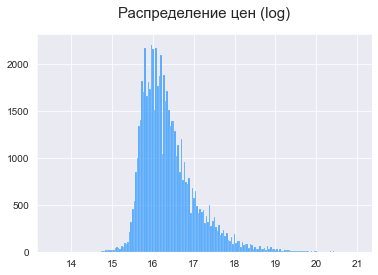

In [92]:
df['price_log'] = np.log(df.price)
ax = sns.histplot(df.price_log, color='dodgerblue');
ax.set(xlabel=None, ylabel=None);
plt.title('Распределение цен (log)', y=1.05, fontsize=15);

Посмотрим на линейные зависимости между log-ценой и остальными переменными.

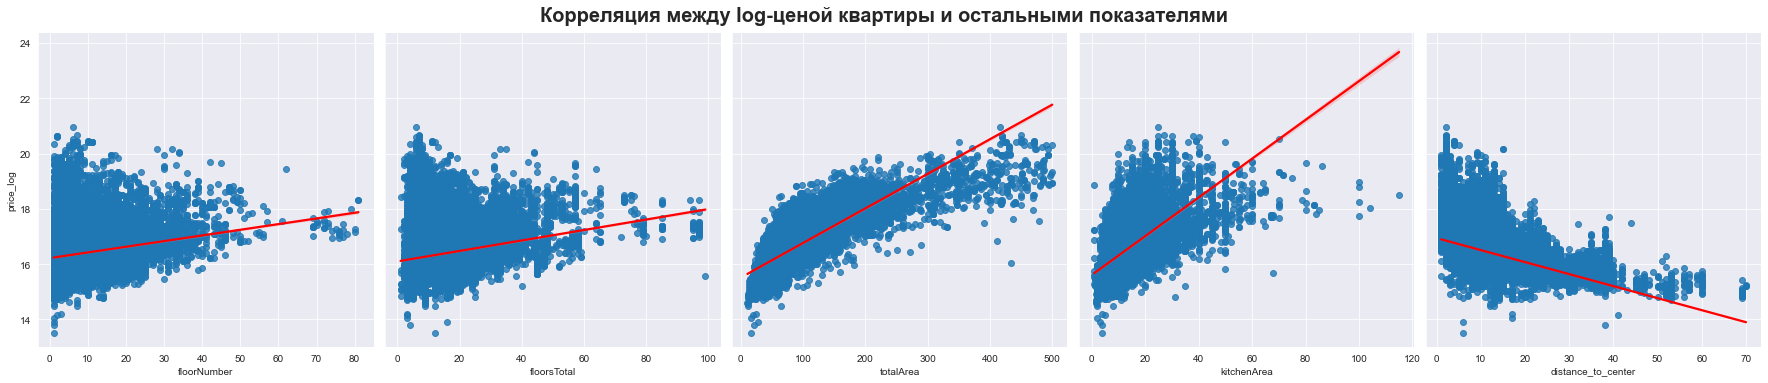

In [93]:
ax = sns.pairplot(data=df,
                  y_vars=['price_log'],
                  x_vars=['floorNumber', 'floorsTotal', 'totalArea', 'kitchenArea', 'distance_to_center'],
                  kind='reg',
                  plot_kws={'line_kws':{'color':'red'}},
                  height=5);

ax.fig.suptitle('Корреляция между log-ценой квартиры и остальными показателями', y=1.05, fontsize=20, fontweight='bold');

- Графики с этажом квартиры и общей этажностью имеют низкую положительную корреляцию
- Площадь наглядно положительно коррелирует с ценой
- Расстояние до центра кореллирует отрицательно

5. Проверка на мультиколлинеарность

*Согласно наиболее распространнёной практике, будем считать значения VIF > 5 слишком большими и колонки, связаннные с ними, требующими удаления.*

In [94]:
considered_features = ['totalArea', 'distance_to_center','kitchenArea', 'floorNumber', 'floorsTotal']


def compute_vif(considered_features):
    
    X = df[considered_features]
    # VIF = 1 означает, что корреляции между одной переменной и другими нет
    X['intercept'] = 1
    
    # Датафрейм для хранения VIF
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif


compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\-002D~1\AppData\Local\Temp/ipykernel_16860/3969038157.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
4,floorsTotal,1.868432
2,kitchenArea,1.849589
3,floorNumber,1.761288
0,totalArea,1.739906
1,distance_to_center,1.035108


Все значения R-squared считались при помощи следующего кода:

In [95]:
# results = smf.ols('price_log ~ X1 + X2 + Xn', df).fit()
# print(results.summary())

В итоге мы получили следующие значения R-squared:

In [96]:
totalArea =  0.662
kitchenArea = 0.370
floorsTotal = 0.056
floorNumber = 0.038
distance_to_center = 0.235

In [97]:
totalArea_kitchenArea  = 0.675
totalArea_floorsTotal = 0.668
totalArea_floorNumber = 0.665
totalArea_distance_to_center =  0.787

In [98]:
totalArea_distance_to_center_kitchenArea = 0.801
totalArea_distance_to_center_floorsTotal = 0.798
totalArea_distance_to_center_floorNumber = 0.792

In [99]:
totalArea_distance_to_center_kitchenArea_floorNumber = 0.804
totalArea_distance_to_center_kitchenArea_floorsTotal = 0.807

2. Проверка на нормальность распредедния остатков

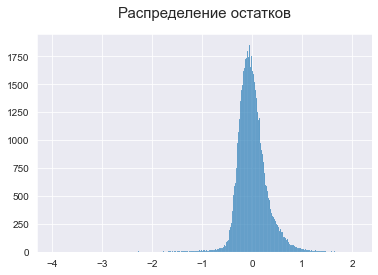

In [100]:
results = smf.ols('price_log ~ totalArea + distance_to_center + kitchenArea + floorsTotal ', df).fit()

sns.histplot(results.resid) 
plt.title('Распределение остатков', y=1.05, fontsize=15);
plt.ylabel(None);

Остатки распределены преимущественно нормально (левый хвост чуть меньше).

4. Проверка на гетероскедастичность. (*Используем для этого scale-location plot*)

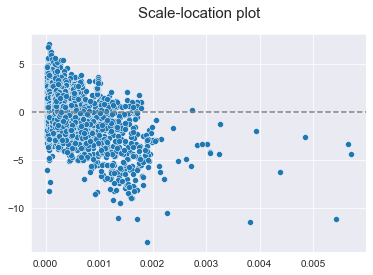

In [101]:
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag


ax = sns.scatterplot(x=leverage, y=stand_resids);
ax.axhline(y=0, color='grey', linestyle='dashed');
plt.title('Scale-location plot', y=1.05, fontsize=15);

Значения случайно разбросаны вокруг нуля, хотя и имеется небольшой патерн вправо вниз => дисперсии переменных примерно одинаковые, гетероскедатичности нет.

<b>Требования для построения модели соблюдены.</b>

## Интеперетация результатов

Так как мы логарифмировали ЗП, теперь произведём обратную операцию - потенцирование.

In [102]:
(np.exp(0.807) - 1) * 100

124.11743681943786

Таким образом, с увеличением значения каждой НП на 1 цена жилья увеливичается на 124%.

---
<font size='4'><b>Выводы</b></font>

Больше всего цена ожидаемо зависит от площади квартиры и кухни. Наибольший R-squared получился при сочетании следующих параметров:
- площадь квартиры
- площадь кухни
- расстояние до Кремля
- этажность

Интересно, что среди определяющих параметров нет этажа, на котором располагается квартира. Как правило, цена в т.ч. зависит от этажа в многоэтажных домах, но эта связь не всегда линейна - слишком высокий этаж может доставить дополнительные трудности (долго дожидаться лифта, сломанный лифт, возможные трудности с транспортировкой мебели). Иными словами, выше -  не значит дороже.

---

## Нанесение данных на карту

Предположим, у нас не так много денег, но мы не хотим жить далеко от центра. Поэтому мы будем искать квартиры, которые удовлетворяют следующим условиям:
- как можно более дешевые
- как можно ближе к центру
- c наибольшей площадью квартиры и кухни.

Выберем первую тысячу квартиру, отфильтрованных таким образом, и нанесем их на карту при помощи библиотеки folium, чтобы иметь визуальное представление того, где они располагаются.

In [103]:
best_flats = df.sort_values(['price', 'distance_to_center', 'totalArea', 'kitchenArea'], \
                            ascending=[True, True, False, False]).head(1000)

In [104]:
moscow_map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=12, control_scale=True)


for index, location_info in best_flats.iterrows():
    folium.Marker([location_info["latitude"], location_info["longitude"]], \
                  popup= folium.Popup(f'''Цена: {location_info["price"]} р.\n
                            Площадь: {location_info["totalArea"]} м2\n
                            Площадь кухни: {location_info["kitchenArea"]} м2\n
                            Этаж: {int(location_info["floorNumber"])},\n
                            Всего этажей: {int(location_info["floorsTotal"])}''', \
                            max_width="150")).add_to(moscow_map)

In [105]:
moscow_map